Let's go.

In [39]:
import pandas as pd

In [40]:
def openData():
    df=pd.read_csv("../data2.csv")
    df.drop_duplicates()
    return df
df=openData()


df=df.dropna(subset=['price'])
# df.drop('rooms',axis=1,inplace=True)
# df.drop('floor',axis=1,inplace=True)
# df.drop('test',axis=1,inplace=True)
# df.drop('averageDistrictValue',axis=1,inplace=True)

df['price']/=1e9
df['averageDistrictValue']/=1e6
df['test']/=1e9
df['age2']=(1403-df['buildYear'])**3
df.reset_index()
df.info()
g=0
cd=[]
with open("errors.txt",'w') as file:
    for i in range(len(df['price'].values)):
        elem=df.iloc[i]
        realPrice=df['price'].values[i]
        error=abs(realPrice-elem['test'])
        if(error>min(elem['test'],realPrice)*0.8):
            file.write(f"{elem}\n\n")
            cd.append(i)
            g+=1
df=df.drop(cd)
elem=df.loc[9]
realPrice=elem['price']
print("(", realPrice)
error=abs(realPrice-elem['test'])
if(error>min(elem['test'],realPrice)*0.8):
    print("gotcha"+"******")
print("Deleted: " , g)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5834 entries, 0 to 5833
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   meter                 5834 non-null   int64  
 1   district              5834 non-null   object 
 2   buildYear             5834 non-null   int64  
 3   rooms                 5834 non-null   int64  
 4   price                 5834 non-null   float64
 5   elevator              5834 non-null   int64  
 6   space                 5834 non-null   int64  
 7   parking               5834 non-null   int64  
 8   floor                 5834 non-null   int64  
 9   averageDistrictValue  5834 non-null   float64
 10  test                  5834 non-null   float64
 11  age2                  5834 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 547.1+ KB
( 2.3
Deleted:  74
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5833
Data columns (total 12

just working a bit with the dataset to understand what's going on. you can pass this.

In [41]:
print(df.describe())

             meter     buildYear        rooms        price    elevator  \
count  5760.000000   5760.000000  5760.000000  5760.000000  5760.00000   
mean     93.242361   1394.171875     1.894792    10.843012     0.74184   
std      48.758107    165.047379     0.737251    12.134713     0.43766   
min      20.000000   1370.000000     0.000000     2.014000     0.00000   
25%      60.000000   1385.000000     1.000000     3.599750     0.00000   
50%      80.000000   1393.000000     2.000000     6.400000     1.00000   
75%     114.000000   1400.000000     2.000000    13.000000     1.00000   
max     600.000000  13902.000000     4.000000    98.000000     1.00000   

             space      parking        floor  averageDistrictValue  \
count  5760.000000  5760.000000  5760.000000           5760.000000   
mean      0.772569     0.860069     2.896528             97.915696   
std       0.419209     0.346945     1.931377             46.953413   
min       0.000000     0.000000     0.000000         

In [42]:
import matplotlib.pyplot as plt

**Deleting the outliers**

2.2 50.0


array([[<AxesSubplot: title={'center': 'meter'}>,
        <AxesSubplot: title={'center': 'buildYear'}>,
        <AxesSubplot: title={'center': 'rooms'}>],
       [<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'elevator'}>,
        <AxesSubplot: title={'center': 'space'}>],
       [<AxesSubplot: title={'center': 'parking'}>,
        <AxesSubplot: title={'center': 'floor'}>,
        <AxesSubplot: title={'center': 'averageDistrictValue'}>],
       [<AxesSubplot: title={'center': 'test'}>,
        <AxesSubplot: title={'center': 'age2'}>, <AxesSubplot: >]],
      dtype=object)

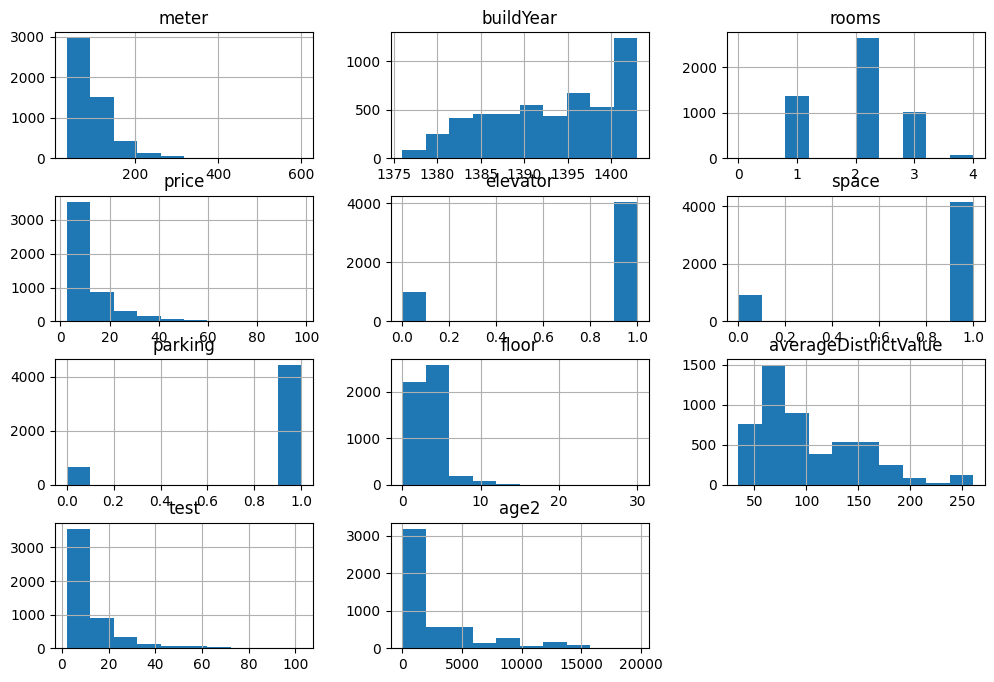

In [43]:
import numpy as np
from scipy import stats
outlierHigh = df["price"].quantile(0.98)
outlierLow = df["price"].quantile(0.02)
df.reset_index()
df=df[(df['price'] > 2.5) & (df['price'] < 100)]
df=df[(df['meter'] > 35) & (df['meter'] < 2000)]
df=df[(df['buildYear'] > 1375) & (df['buildYear'] < 1404)]
df=df[(df['district'].str.contains("[^chitgar]"))] # never learned regex :P
df=df[(df['district'].str.contains("[lake]"))] # never learned regex :P


print(outlierLow,outlierHigh)
df.describe()
df.hist(figsize=(12,8))

**making the test set**

In [44]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [45]:
df=df.reset_index()

train_set, test_set = split_data_with_id_hash(df, 0.2, "index")

stratified sampling:

count    5069.000000
mean       11.616224
std        12.564799
min         2.510000
25%         3.980000
50%         7.020000
75%        14.000000
max        98.000000
Name: price, dtype: float64


Text(0, 0.5, 'Number of districts')

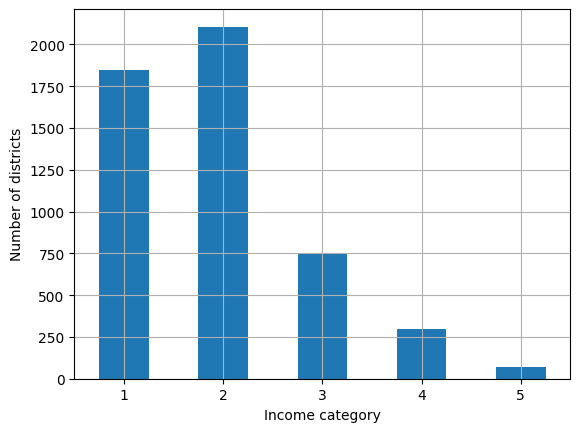

In [46]:
print(df['price'].describe())
df["cat"] = pd.cut(df["price"].astype(float),
bins=[0., 5, 15, 30, 60, np.inf],
labels=[1, 2, 3, 4, 5])
df["cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(df, df["cat"]):
    stratTrainSetN = df.iloc[trainIndex]
    stratTestSetN = df.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])

print(df.info())
try:
    df=df.drop(['index','age2','line'],axis=1)
except: pass

stratTrainSet, stratTestSet = stratSplits[0]
g=0
cd=[]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5069 entries, 0 to 5068
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   meter                 5069 non-null   int64   
 1   district              5069 non-null   object  
 2   buildYear             5069 non-null   int64   
 3   rooms                 5069 non-null   int64   
 4   price                 5069 non-null   float64 
 5   elevator              5069 non-null   int64   
 6   space                 5069 non-null   int64   
 7   parking               5069 non-null   int64   
 8   floor                 5069 non-null   int64   
 9   averageDistrictValue  5069 non-null   float64 
 10  test                  5069 non-null   float64 
 11  cat                   5069 non-null   category
dtypes: category(1), float64(3), int64(7), object(1)
memory usage: 440.9+ KB
None


In [64]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("cat", axis=1 , inplace=True)

/tmp/ipykernel_28068/1832761340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("cat", axis=1 , inplace=True)
/tmp/ipykernel_28068/1832761340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [65]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price                   1.000000
test                    0.955054
meter                   0.860192
averageDistrictValue    0.778895
rooms                   0.641701
space                   0.277783
elevator                0.271405
floor                   0.242037
parking                 0.199196
buildYear               0.174028
Name: price, dtype: float64


/tmp/ipykernel_28068/3448244544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house.corr()


_note 1_ : wow it seems that meter is really important!

In [66]:
house = stratTrainSet.drop('price',axis=1)
labels = stratTrainSet[['price']].copy()

**And finally The PIPELINE**

In [67]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from math import log10

houseNum=house.select_dtypes(np.number)

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("normal",StandardScaler())
])
class Log(BaseEstimator, TransformerMixin):
    def __init__(self):
        return 
    def fit(self, X, y = None):
        return self
    
    def transform(self, x):
        for i in range(len(x)):
            x[i][0]=log10(x[i][0])
        return x
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown='ignore')
)
avg_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
Log()
)
preprocessing = ColumnTransformer(
    [("cats",cat_pipeline,['district']),
    ("avg",avg_pipeline,['test','averageDistrictValue'])
    ]
    ,remainder=num_pipeline
)

preprocessing.fit(house)
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                             SimpleImputer(strategy='most_frequent')),
                                            ('normal', StandardScaler())]),
                  transformers=[('cats',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['district']),
                                ('avg',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('log', Log())]),
                                 ['test', 'averageDistrictValue'])])

**Train**

**Really, Really Testing for overfitting**

In [68]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=4))
print(sklearn.metrics.get_scorer_names())
#forest_mpae = -cross_val_score(forest_reg, house, labels['price'],cv=3,scoring="neg_mean_absolute_percentage_error")

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

meter                          70
district                    ahang
buildYear                    1403
rooms                           1
price                         2.9
elevator                        1
space                           1
parking                         0
floor                           3
averageDistrictValue    72.404904
test                     5.068343
Name: 1992, dtype: object 5.494549999999996
meter                              85
district                tehran-zanjan
buildYear                        1390
rooms                               2
price                             3.8
elevator                            0
space                               1
parking                             1
floor                               4
averageDistrictValue        73.353534
test                          6.23505
Name: 2746, dtype: object 5.704860000000002
0.8081510934393639 *********
{'dezashib': 2, 'tayeb': 1, 'zafar': 1, 'abshar-tehran': 1, 'hesar-booali': 1, 'ahang': 1, 

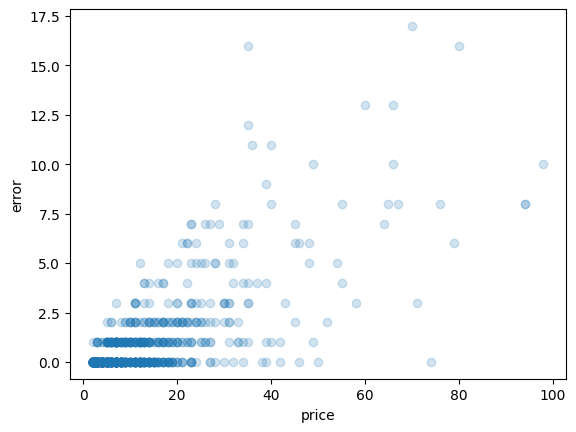

In [70]:

#print(forest_mae.mean()) --> 0.11 = 11%
forest_reg.fit(house,labels['price'])

housing_predictions = forest_reg.predict(house)


X_test = stratTestSet.drop("price", axis=1)
y_test = stratTestSet[["price"]].copy()

final_predictions = forest_reg.predict(X_test)
a=[[],[]]
b=[[],[]]
dis={}
c=0

for i in range(len(y_test)):
    realPrice=y_test.values[i]
    error=abs(realPrice-final_predictions[i])
    if(error>min(final_predictions[i],realPrice)*0.5):
        b[0].append(error)
        b[1].append(realPrice)
        elem=stratTestSet.iloc[i]
        if(realPrice<4):
            print(elem,final_predictions[i])
        if(elem['district'] in dis): 
            dis[elem['district']]+=1
        else: 
            dis[elem['district']]=1
    else:
        a[0].append(int(error))
        a[1].append(int(realPrice))
        c+=error
print(sum(a[0])/len(a[0]),"*********")
print( {k: v for k, v in sorted(dis.items(), key=lambda item: item[1],reverse=True)})
print(len(b[1]),len(b[0]))
plt.scatter(a[1],a[0],alpha=0.2)
plt.xlabel("price")
plt.ylabel("error")
plt.show()

getting output:


In [71]:
import joblib
joblib.dump(forest_reg, "model.pkl")

['model.pkl']